In [1]:
# Urban Heat Island Analysis - Berlin
# Author: Medhansh Ahuja
# Course: Applications 2 – Urban Technologies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Urban Heat Berlin Jupyter Notebook Started Successfully!")

Urban Heat Berlin Jupyter Notebook Started Successfully!


In [2]:
pip install osmnx

Note: you may need to restart the kernel to use updated packages.


In [1]:
import osmnx as ox
import geopandas as gpd

# Download Berlin city boundary
berlin = ox.geocode_to_gdf("Berlin, Germany")

print("Berlin boundary loaded successfully!")
berlin

Berlin boundary loaded successfully!


,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((13.08834 52.41963, 13.09021 52...",13.088345,52.338245,13.761161,52.675509,134060781,relation,62422,52.517389,13.395131,boundary,administrative,8,0.840425,city,Berlin,"Berlin, Germany"


In [3]:
# Download Berlin districts (Bezirke) from OpenStreetMap - OSMnx 2.x compatible

districts = ox.features_from_place(
    "Berlin, Germany",
    tags={"boundary": "administrative", "admin_level": "8"}
)

print("Raw OSM district objects:", len(districts))
districts.head()

Raw OSM district objects: 197


geometry  \
element  id                                                         
relation 16328  POLYGON ((13.30038 52.56998, 13.3019 52.57144,...   
         16330  POLYGON ((13.26423 52.62686, 13.26438 52.62802...   
         16334  POLYGON ((13.2082 52.59899, 13.20724 52.59987,...   
         16343  POLYGON ((13.10932 52.45071, 13.10956 52.45108...   
         16346  POLYGON ((13.27034 52.54934, 13.27061 52.54934...   

                      boundary                 name  ref admin_level name:ab  \
element  id                                                                    
relation 16328  administrative        Reinickendorf  NaN          10     NaN   
         16330  administrative              Frohnau  NaN          10     NaN   
         16334  administrative        Reinickendorf  NaN           9     NaN   
         16343  administrative              Spandau  NaN           9     NaN   
         16346  administrative  Charlottenburg-Nord  NaN          10     NaN   

               name:af name:als name:am name:an  ... name:prefix:city  \
element  id                                      ...                    
relation 16328     NaN      NaN     NaN     NaN  ...              NaN   
         16330     NaN      NaN     NaN     NaN  ...              NaN   
         16334     NaN      NaN     NaN     NaN  ...              NaN   
         16343     NaN      NaN     NaN     NaN  ...              NaN   
         16346     NaN      NaN     NaN     NaN  ...              NaN   

               name:prefix:state ref:nuts:1 ref:nuts:2  \
element  id                                              
relation 16328               NaN        NaN        NaN   
         16330               NaN        NaN        NaN   
         16334               NaN        NaN        NaN   
         16343               NaN        NaN        NaN   
         16346               NaN        NaN        NaN   

               report_problems:website state_code alt_name:cs alt_name:pt  \
element  id                                                                 
relation 16328                     NaN        NaN         NaN         NaN   
         16330                     NaN        NaN         NaN         NaN   
         16334                     NaN        NaN         NaN         NaN   
         16343                     NaN        NaN         NaN         NaN   
         16346                     NaN        NaN         NaN         NaN   

               ref:old admin_centre:postal_code  
element  id                                      
relation 16328     NaN                      NaN  
         16330     NaN                      NaN  
         16334     NaN                      NaN  
         16343     NaN                      NaN  
         16346     NaN                      NaN  

[5 rows x 391 columns]

In [4]:
# Keep only polygon geometries (real district boundaries)
districts_clean = districts[districts.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
districts_clean = districts_clean.reset_index(drop=True)

print("Clean district polygons:", len(districts_clean))
districts_clean[["name", "geometry"]].head()

Clean district polygons: 193


,name,geometry
0,Reinickendorf,"POLYGON ((13.30038 52.56998, 13.3019 52.57144,..."
1,Frohnau,"POLYGON ((13.26423 52.62686, 13.26438 52.62802..."
2,Reinickendorf,"POLYGON ((13.2082 52.59899, 13.20724 52.59987,..."
3,Spandau,"POLYGON ((13.10932 52.45071, 13.10956 52.45108..."
4,Charlottenburg-Nord,"POLYGON ((13.27034 52.54934, 13.27061 52.54934..."


In [5]:
# Inspect available admin levels
districts_clean["admin_level"].value_counts()

admin_level
10    98
9     40
8     26
11    16
6      9
4      2
2      1
7      1
Name: count, dtype: int64

In [6]:
# Official list of Berlin Bezirke
bezirke_namen = [
    "Mitte",
    "Friedrichshain-Kreuzberg",
    "Pankow",
    "Charlottenburg-Wilmersdorf",
    "Spandau",
    "Steglitz-Zehlendorf",
    "Tempelhof-Schöneberg",
    "Neukölln",
    "Treptow-Köpenick",
    "Marzahn-Hellersdorf",
    "Lichtenberg",
    "Reinickendorf"
]

# Keep only rows that match official Bezirk names
bezirke_raw = districts_clean[districts_clean["name"].isin(bezirke_namen)].copy()

print("Raw Bezirk parts (before dissolve):", len(bezirke_raw))
bezirke_raw["name"].value_counts()

Raw Bezirk parts (before dissolve): 18


name
Reinickendorf                 2
Spandau                       2
Mitte                         2
Neukölln                      2
Pankow                        2
Lichtenberg                   2
Steglitz-Zehlendorf           1
Treptow-Köpenick              1
Friedrichshain-Kreuzberg      1
Tempelhof-Schöneberg          1
Marzahn-Hellersdorf           1
Charlottenburg-Wilmersdorf    1
Name: count, dtype: int64

In [7]:
# Dissolve all fragments into one polygon per Bezirk
bezirke = bezirke_raw.dissolve(by="name", as_index=False)

print("Final Bezirke count:", len(bezirke))
bezirke[["name", "geometry"]]

Final Bezirke count: 12


,name,geometry
0,Charlottenburg-Wilmersdorf,"POLYGON ((13.18817 52.47184, 13.18829 52.47418..."
1,Friedrichshain-Kreuzberg,"POLYGON ((13.36858 52.49396, 13.36841 52.49448..."
2,Lichtenberg,"POLYGON ((13.51699 52.53541, 13.51706 52.53542..."
3,Marzahn-Hellersdorf,"POLYGON ((13.51688 52.53555, 13.51704 52.53556..."
4,Mitte,"POLYGON ((13.40419 52.5404, 13.4047 52.54019, ..."
5,Neukölln,"POLYGON ((13.39992 52.41854, 13.40012 52.41877..."
6,Pankow,"MULTIPOLYGON (((13.38845 52.56775, 13.38905 52..."
7,Reinickendorf,"POLYGON ((13.34913 52.5892, 13.34979 52.58891,..."
8,Spandau,"POLYGON ((13.10956 52.45108, 13.10973 52.45132..."
9,Steglitz-Zehlendorf,"POLYGON ((13.08834 52.41963, 13.09584 52.42198..."


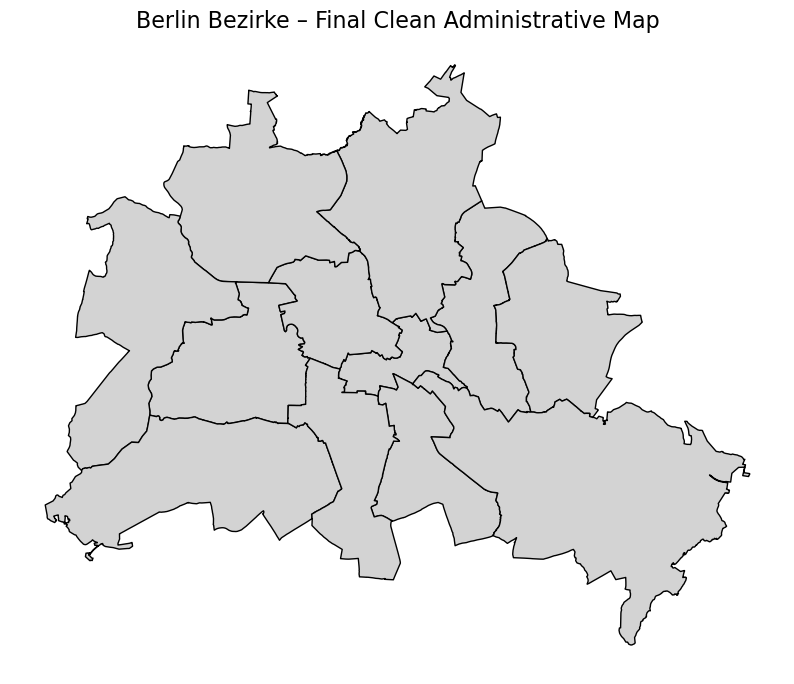

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
bezirke.plot(ax=ax, edgecolor="black", facecolor="lightgray")
ax.set_title("Berlin Bezirke – Final Clean Administrative Map", fontsize=16)
plt.axis("off")
plt.show()